In [71]:
import pandas as pd
import geopandas as gpd
import shapely
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from geoalchemy2 import Geometry, WKTElement
import  sqlalchemy 
from scipy.optimize import lsq_linear
from shapely.geometry import MultiLineString

pd.options.display.max_rows = 100
pd.options.display.max_columns = 200

pg = open('db_credentials.txt')
db = pg.read()
pg.close()
engine = sqlalchemy.create_engine(db)

In [13]:
lion_clipped = gpd.read_postgis('SELECT * FROM lion_clipped', engine, geom_col='shape')
taxis_clipped = gpd.read_postgis('SELECT * FROM taxis_2015_clipped', engine, geom_col='pickup_point')
nodes_clipped = gpd.read_postgis('SELECT * FROM node_clipped', engine, geom_col='shape')

In [32]:
lion_clipped['nodeidfrom'] = lion_clipped['nodeidfrom'].astype(int)
lion_clipped['nodeidto'] = lion_clipped['nodeidto'].astype(int)
lion_clipped['weight'] = lion_clipped['shape_length'].apply(lambda x : {'weight' : x})

lion_clipped['node_low'] = lion_clipped.apply(lambda x : min(x['nodeidto'], x['nodeidfrom']), axis = 1)
lion_clipped['node_high'] = lion_clipped.apply(lambda x : max(x['nodeidto'], x['nodeidfrom']), axis = 1)

lion_filt = lion_clipped.drop_duplicates(subset=['node_low','node_high'], keep='first', inplace=False).reset_index(drop=True)
lion_filt['seg_id'] = np.arange(lion_filt.shape[0])
lion_filt.set_index(['node_low','node_high'], inplace = True)

In [33]:
G = nx.Graph()
G.add_nodes_from(nodes_clipped['nodeid'].astype(int))
edges = list(lion_filt[['nodeidfrom','nodeidto','weight']].to_records(index=False))
G.add_edges_from(edges)

In [34]:
paths_all = dict(nx.all_pairs_dijkstra_path(G,weight = 'weight'))

In [35]:
taxis_clipped = taxis_clipped[taxis_clipped['nn_pickup'] != taxis_clipped['nn_dropoff']]
taxis_clipped['datetime_pickup'] = pd.to_datetime(taxis_clipped['tpep_pickup_datetime'])
taxis_clipped['datetime_dropoff'] = pd.to_datetime(taxis_clipped['tpep_dropoff_datetime'])
taxis_clipped['trip_time'] = taxis_clipped.apply(lambda x: (x['datetime_dropoff']-x['datetime_pickup']).seconds, axis = 1)

In [63]:
def getPathData(p):
    p_seg_ids = []
    p_seg_lengths = []
    p_seg_shapes = []
    for i in np.arange(1,len(p)):
        nodes_temp = [p[i], p[i-1]]
        node_min = min(nodes_temp)
        node_max = max(nodes_temp)
        row = lion_filt.loc[(node_min,node_max)]
        p_seg_ids.append(int(row['seg_id']))
        p_seg_lengths.append(float(row['shape_length']))
        for shape in row['shape']:
            p_seg_shapes.append(shape)
    return p_seg_ids, p_seg_lengths, MultiLineString(p_seg_shapes)

In [65]:
taxis_clipped['path'] = '' 
taxis_clipped['path_distance_mi'] = 0
taxis_clipped['seg_ids'] = ''
taxis_clipped['seg_lengths'] = ''
taxis_clipped['path_shape'] = ''

trip_idx = taxis_clipped.index

for i in trip_idx:
    start_node = taxis_clipped.loc[i,'nn_pickup']
    end_node = taxis_clipped.loc[i,'nn_dropoff']
    path = paths_all[start_node][end_node]
    taxis_clipped.at[i, 'path'] = path
    seg_ids, seg_lengths, path_shape = getPathData(path)
    taxis_clipped.loc[i, 'path_distance_mi'] = np.array(seg_lengths).sum()/5280
    taxis_clipped.at[i,'seg_lengths'] = seg_lengths
    taxis_clipped.at[i, 'seg_ids'] = seg_ids
    taxis_clipped.at[i, 'path_shape'] = path_shape
    
taxis_clipped['dist_error'] = (taxis_clipped['trip_distance'] - taxis_clipped['path_distance_mi']).abs()

In [66]:
bins = np.arange(0,3.4,0.2)
labels = bins[0:-1] + 0.1

taxis_clipped['dbin'] = pd.cut(taxis_clipped['trip_distance'], bins=bins, labels = labels)
lower = taxis_clipped.groupby('dbin')['trip_time'].quantile(0.05)
upper = taxis_clipped.groupby('dbin')['trip_time'].quantile(0.95)
lower_arr = pd.DataFrame(lower).reset_index().to_numpy()
upper_arr = pd.DataFrame(upper).reset_index().to_numpy()


from scipy.interpolate import UnivariateSpline
spl_lower = UnivariateSpline(lower_arr[:,0],lower_arr[:,1])
spl_upper = UnivariateSpline(upper_arr[:,0],upper_arr[:,1])

taxis_clipped['trip_time_p5'] = taxis_clipped['trip_distance'].apply(lambda x : float(spl_lower(x)))
taxis_clipped['trip_time_p95'] = taxis_clipped['trip_distance'].apply(lambda x : float(spl_upper(x)))

In [67]:
taxis_clipped['filt'] = taxis_clipped.apply(lambda x : \
                                            (x['trip_distance'] >= 0.5) \
                                            and (x['trip_distance'] <= 2) \
                                            and (x['trip_time'] >= x['trip_time_p5']) \
                                            and (x['trip_time'] <= x['trip_time_p95']) \
                                            and (x['dist_error'] < 0.4), axis = 1)

taxis_filt = taxis_clipped[taxis_clipped['filt']].reset_index()

In [69]:
trip_filt_idx = taxis_filt.index
num_segments = lion_filt.shape[0]
A = np.zeros([len(trip_filt_idx), num_segments])

for i in trip_filt_idx:
    seg_coefs = np.zeros(num_segments)
    seg_coefs[taxis_filt.loc[i,'seg_ids']] = taxis_filt.loc[i,'seg_lengths']
    A[i] = seg_coefs

In [85]:
b = taxis_filt['trip_time'] 
lb = np.zeros(num_segments)
ub = np.ones(num_segments)*0.4

x = lsq_linear(A, b, bounds = (lb, ub))

In [75]:
x

 active_mask: array([-1,  0,  0, ...,  0,  0, -1])
        cost: 139767721.47992587
         fun: array([  56.58965638,  -73.90710326,    2.71445407, ...,  145.95494858,
        -52.80081446, -133.43150513])
     message: 'The relative change of the cost function is less than `tol`.'
         nit: 85
  optimality: 0.0038342044335001393
      status: 2
     success: True
           x: array([3.80006745e-17, 1.19838867e+01, 1.71187095e+00, ...,
       2.80267483e-01, 2.41086184e-01, 2.03533304e-14])

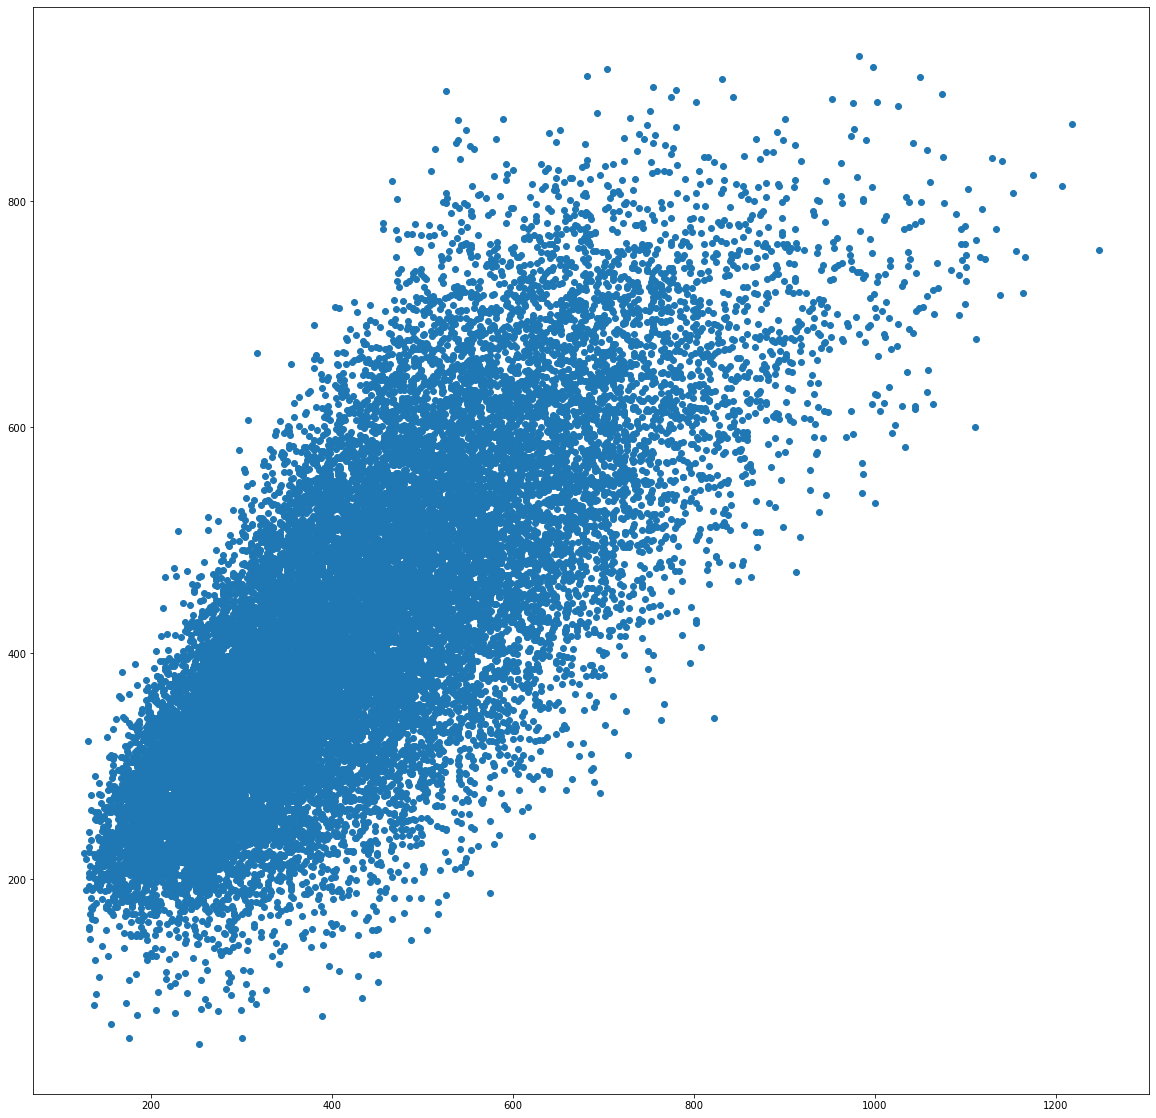

In [86]:
pred = np.matmul(A, x['x'])

plt.figure(figsize=(20,20))
plt.scatter(b, pred)

(array([ 15.,   5.,  11.,  22.,  28.,  33.,  52.,  73.,  65.,  61.,  63.,
         79.,  65.,  74.,  66.,  64.,  56.,  56.,  48.,  54.,  63.,  57.,
         44.,  46.,  51., 182.,  45.,  49.,  39.,  38.,  31.,  22.,  37.,
         29.,  23.,  25.,  15.,  25.,  27.,  14.,  19.,  13.,  16.,  21.,
         16.,  14.,  11.,   9.,  15.,  13.,  11.,  15.,  12.,  12.,   9.,
         10.,  12.,  12.,  14.,  11.,  10.,   4.,   8.,  10.,   5.,   4.,
          9.,   5.,   7.,  10.,   5.,   4.,   8.,   6.,   7.,  22.,   3.,
          6.,   4.,  10.,   7.,   8.,   8.,   7.,   8.,   5.,   3.,   7.,
          7.,   3.,  10.,  12.,   4.,   9.,   4.,   7.,   5.,   6.,   7.,
         25.]),
 array([0.   , 0.004, 0.008, 0.012, 0.016, 0.02 , 0.024, 0.028, 0.032,
        0.036, 0.04 , 0.044, 0.048, 0.052, 0.056, 0.06 , 0.064, 0.068,
        0.072, 0.076, 0.08 , 0.084, 0.088, 0.092, 0.096, 0.1  , 0.104,
        0.108, 0.112, 0.116, 0.12 , 0.124, 0.128, 0.132, 0.136, 0.14 ,
        0.144, 0.148, 0.152, 0.156

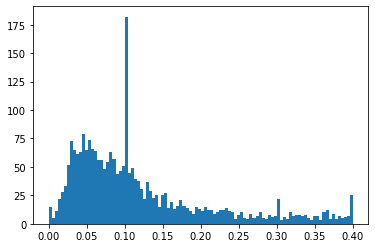

In [87]:
plt.hist(x['x'], range=[0,0.4], bins = 100)